# Initial Python Setup
First, we'll need to import the related libraries that will be used in this scirpt


In [22]:
import os
import pandas as pd
import requests as req
import numpy as np
import statsmodels.api as stapi
import statsmodels.formula.api as smf

from zipfile import ZipFile
from io import BytesIO
from IPython.display import display
from matplotlib import rc as pltrc
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults, RegressionResultsWrapper

Next, we'll set up some initial variables and configuration, such as links and display options


In [2]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

pltrc('font', size=10)

# Importing the Dataset
Here, we will download and extract the dataset. We'll be doing the entire process in-memory, so you will not need to worry about any additional files being saved to your computer

In [3]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))

Now, the dataframe is stored in the `df` variable, and looks like the following:

In [4]:
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

# Data Cleaning
Now, the data won't work in the original state. As stated in the report, many of the variables are actually multi-selectable lists. The variables are stored as strings, using `;` as a separator.

We'll create new dataframes for each of these. In this step, we'll also need to rename some of the new columns to avoid including spaces or characters we can't use in regression.

In [5]:
df_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';').rename(columns={
  "C#": "CSharp",
  "F#": "FSharp",
  "Bash/Shell": "Bash",
  "HTML/CSS": "HTML",
  "Objective-C": "ObjectiveC",
  "C++": "CPP"
}).add_prefix("WorksIn_")

df_devtype = df["DevType"].str.get_dummies(";").rename(columns={
  "Academic researcher": "AcademicResearcher",
  "Cloud infrastructure engineer": "CloudInfrastructureEngineer",
  "Data or business analyst": "DataBusinessAnalyst",
  "Data scientist or machine learning specialist": "DataScientistMachineLearning",
  "Database administrator": "DatabaseAdministrator",
  "DevOps specialist": "DevOpsSpecialist",
  "Developer, QA or test": "DevQATest",
  "Developer, back-end": "DevBackend",
  "Developer, desktop or enterprise applications": "DevDesktopApps",
  "Developer, embedded applications or devices": "DevEmbedded",
  "Developer, front-end": "DevFrontend",
  "Developer, full-stack": "DevFullstack",
  "Developer, game or graphics": "DevGame",
  "Developer, mobile": "DevMobile",
  "Engineer, data": "DataEngineer",
  "Engineer, site reliability": "SiteReliabilityEngineer",
  "Engineering manager": "EngineerManager",
  "Marketing or sales professional": "MarketingSales",
  "Other (please specify):": "Other",
  "Product manager": "ProductManager",
  "Project manager":"ProjectManager",
  "Security professional": "Security",
  "Senior Executive (C-Suite, VP, etc.)": "SeniorExec",
  "System administrator": "SystemAdmin"
}).add_prefix("DevType_")

df_employment = df["Employment"].str.get_dummies(";").rename(columns={
  "Employed, full-time": "FullTime",
  "Employed, part-time": "PartTime",
  "I prefer not to say": "Unknown",
  "Independent contractor, freelancer, or self-employed": "SelfEmployed",
  "Not employed, and not looking for work": "UnemployedNotLooking",
  "Not employed, but looking for work": "UnemployedLooking",
  "Student, full-time": "StudentFullTime",
  "Student, part-time": "StudentPartTime"
}).add_prefix("Employed_")

Each of these dataframes contain a column for every possible choice found in the dataset. For example, the `dummy_languages` contains each of the languages found in the dataset as follows:

In [6]:
display(df_languages)

,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_CPP,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
73264,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
73265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
73266,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


If the person indicated that they have worked with the language, there will be a `1`. Otherwise, there will be a `0`.

Now, we can simply overwrite `df` to append these sub-dataframes into the main dataframe

In [7]:
df = pd.concat([df,df_languages, df_devtype, df_employment], axis = 1)

Next, some of the numeric columns have entries for extremities. For example, the `YearsCode` column can have the value `"Less than 1 year"` or `"More than 50 years"`, which can be problematic if we try to use them in our regression.

For simplification, we'll assume that `"Less than 1 year"` is `0`, and `"More than 50 years"` is `50`


In [8]:
df["NumYearsCode"] = pd.to_numeric(
  df["YearsCode"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

df["NumYearsCodePro"] = pd.to_numeric(
  df["YearsCodePro"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

Similarly, the text data for education level is bloated, so we will be replacing those in order to make our regression outputs cleaner

In [9]:
df["EducationLevel"] = df["EdLevel"].replace({
  "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "MastersDegree",
  "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "BachelorsDegree",
  "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "SecondarySchool",
  "Some college/university study without earning a degree": "SomeCollege",
  "Something else": "SomethingElse",
  "Primary/elementary school": "PrimarySchool",
  "Other doctoral degree (Ph.D., Ed.D., etc.)": "DoctoralDegree",
  "Associate degree (A.A., A.S., etc.)": "AssociatesDegree",
  "Professional degree (JD, MD, etc.)": "ProfessionalDegree"
})

# Filtering Data
Not all of the data can be useful to us. Entries come from across the world, get paid in different currencies, and not to mention some may put in false information. 

In order to get a dataset we can reliably use, we will first restrict our analysis on individuals in the United States. 

Next, we'll only use individuals who have the `"ConvertedCompYearly"` variable filled in. It appears that some of the outlier do not have this variable, so it may be StackOverflow's filtering to remove significant outliers

We will also remove any entries with any "unknown" values, such as having an unknown employment status

In [76]:
df_filtered = df[
  (df["Country"] == "United States of America") & 
  (df["ConvertedCompYearly"].notna()) &
  (df["Employed_Unknown"] == 0)
]

Our data is now filtered properly, and ready to be analyzed

In [77]:
display(df_filtered)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_CPP,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA,DevType_AcademicResearcher,DevType_Blockchain,DevType_CloudInfrastructureEngineer,DevType_DataBusinessAnalyst,DevType_DataScientistMachineLearning,DevType_DatabaseAdministrator,DevType_Designer,DevType_DevOpsSpecialist,DevType_DevQATest,DevType_DevBackend,DevType_DevDesktopApps,DevType_DevEmbedded,DevType_DevFrontend,DevType_DevFullstack,DevType_DevGame,DevType_DevMobile,DevType_Educator,DevType_DataEngineer,DevType_SiteReliabilityEngineer,DevType_EngineerManager,DevType_MarketingSales,DevType_Other,DevType_ProductManager,DevType_ProjectManager,DevType_Scientist,DevType_Security,DevType_SeniorExec,DevType_Student,DevType_SystemAdmin,Employed_FullTime,Employed_PartTime,Employed_Unknown,Employed_SelfEmployed,Employed_UnemployedNotLooking,Employed_UnemployedLooking,Employed_Retired,Employed_StudentFullTime,Employed_StudentPartTime,NumYearsCode,NumYearsCodePro,EducationLevel
11,12,"I am not primarily a developer, but I write co...","Employed, full-time;Independent contractor, fr...",Fully remote,Hobby;Contribute to open-source projects;Freel...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,NaN,12,10,Engineering manager,20 to 99 employees,I have some influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,194400.0,Yearly,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js,.NET;Keras;NumPy;Pandas;Scikit-learn;TensorFlo...,Keras;NumPy;Pandas;Scikit-learn;TensorFlow;Tor...,Docker;Homebrew;Kubernetes,Docker;Homebrew;Kubernetes;Pulumi;Terraform,IPython/Jupyter;Neovim;Visual Studio;Visual St...,IPython/Jupyter;Neovim;Visual Studio Code,Linux-based;macOS;Windows,Linux-based;macOS,Git,Code editor;Dedicated version control GUI appl...,NaN,NaN,Confluence;Jira Work Management;Notion;Trello,Notion;Trello,Cisco Webex Teams;Google Chat;Microsoft Teams;

# Helper Functions

To make things easier, I'll create a bunch of functions here that help automate the displaying of plots (which can be copied into the report).



This function helps us by simply removing the first section of our new variables (so `WorksIn_Python` results in `Python`)


In [78]:
def removePrefix(string: str):
  return string[string.find('_')+1:]

This function will help visualize the effects of each column. By default, it will be set to show the languages, but it is configurable for my needs further on

In [81]:
def showLanguageCoefficientPlot(
    regression: RegressionResultsWrapper, 
    columns: list[str] = list(df_languages.columns),
    fig_size = (30,10),
    y_scale_factor = 1,
    ylabel="Change in Salary",
    xlabel="Variable (From lowest to highest change in salary)",
    remove_underscore = True,
    replace_underscore_with_space = True,
    font_size=15,
    title="Variable Coefficients",
    rotate_xticks = -90
  ):

  reg: RegressionResults = regression #type: ignore
  table: pd.DataFrame = reg.summary2().tables[1]
  table = table[table.index.isin(columns)]
  table = table.sort_values(by=["Coef."])
  
  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  pltrc('font', size=font_size)
  plt.figure(figsize = fig_size)
  plt.xticks(rotation=rotate_xticks)
  barcontainer = plt.bar(table.index,table["Coef."] * y_scale_factor)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  return plt


We'll also need to be able to get the columns from the sub-dataframes

In [52]:
def cols(df: pd.DataFrame) -> list[str]:
  return list(df.columns)

And a way to join them into a `" + "` separated string

In [50]:
def add(vals: list[str]) -> str:
  return " + ".join(vals)

# Analysis
Now, we get into the fun part. I won't have much of the explanation here, since that's the purpose of the report. However, I'll try to include a basic idea of what each part is


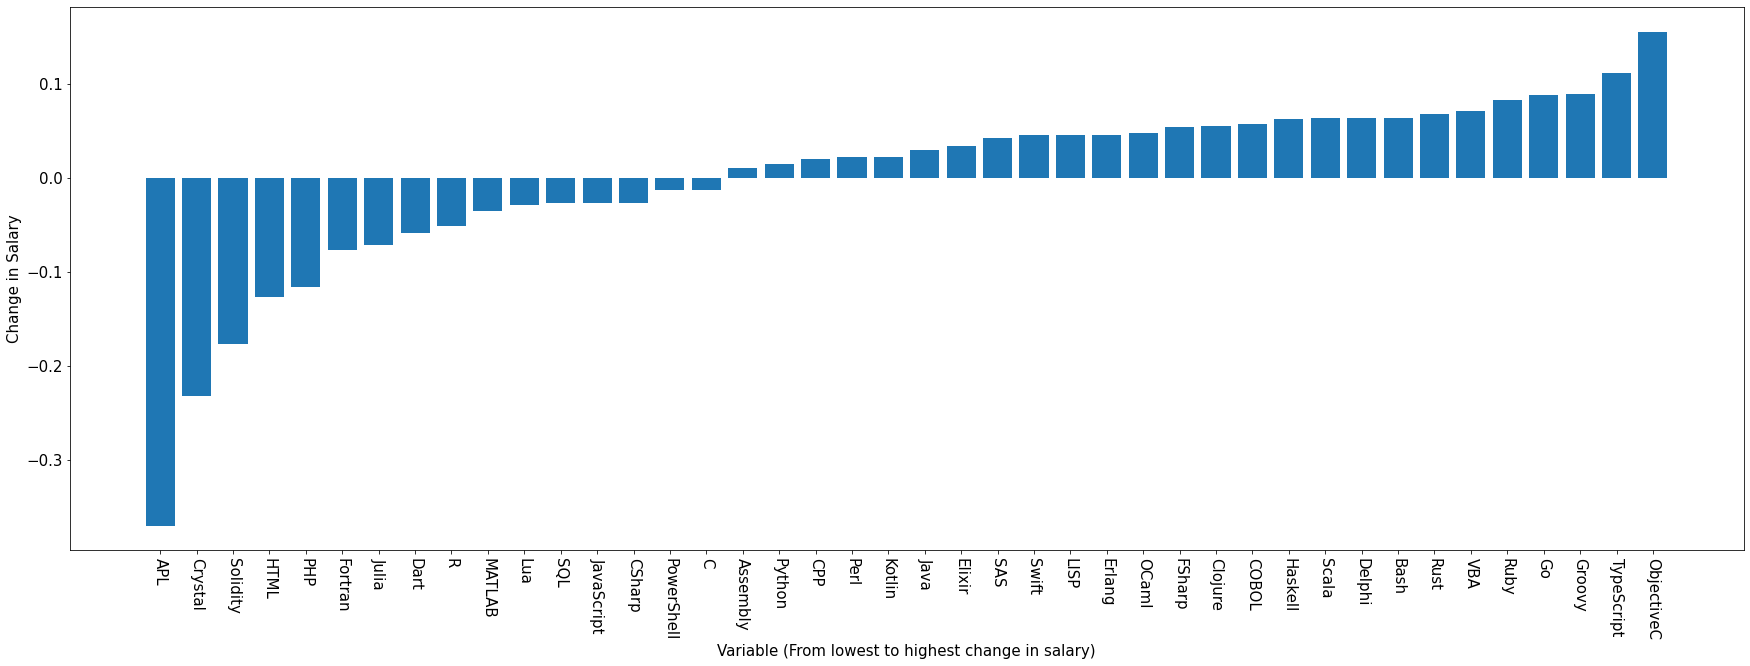

In [96]:
ols_basic = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages) + cols(df_devtype) + cols(df_employment))} + NumYearsCode + NumYearsCodePro + EducationLevel", data = df_filtered).fit()
showLanguageCoefficientPlot(
  ols_basic,
  columns = cols(df_languages)
).show()